In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Generation of synthetic data

In [2]:
df = pd.read_csv('signal.txt',header=None)
x = np.asarray(df)

Create T using the exponential sampling strategy : $$(\forall n \in\{1, \ldots, N\}) \quad T^{(n)}=T_{\min } \exp \left(-(n-1) \frac{\log \left(T_{\min } / T_{\max }\right)}{N-1}\right)$$
And create t using the regular sampling strategy : $$(\forall m \in\{1, \ldots, M\}) \quad t^{(m)}=t_{\min }+\frac{m-1}{M-1}\left(t_{\max }-t_{\min }\right)$$
Then, K is created using : $$(\forall m \in\{1, \ldots, M\})(\forall n \in\{1, \ldots, N\}) \quad K^{(m, n)}=\exp \left(-T^{(n)} t^{(m)}\right)$$

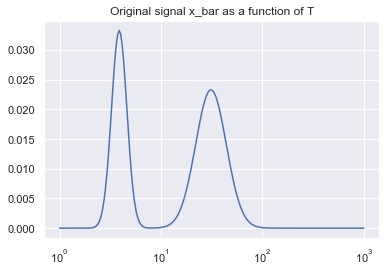

In [3]:
def exp_T(n, Tmin, Tmax, N):
    """
    Exponential sampling strategy
    """
    return Tmin * np.exp(- (n - 1) * np.log( Tmin / Tmax ) / (N - 1)) 

def reg_T(m, tmin, tmax, M):
    """
    Regular sampling strategy
    """
    return tmin + (tmax - tmin) * (m-1)/ (M - 1) 

N = 200
n = np.arange(N)+1
T_n_exp = exp_T(n, 1, 1000, N)

fg, ax  = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(T_n_exp, x)
ax.set_title('Original signal x_bar as a function of T')

M = 50
m = np.arange(M)+1
T_n_reg = reg_T(m, 0, 1.5, M)

K = np.exp(-T_n_reg.reshape(-1,1) @ T_n_exp.reshape(-1,1).T)

Text(0.5, 1.0, 'Resulting noisy data y as a function of t')

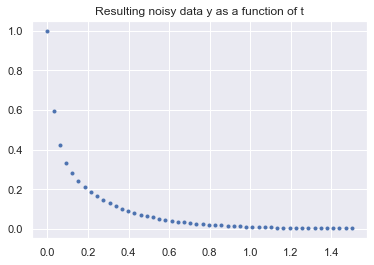

In [4]:
z = K @ x
sigma_2 = np.square(1e-2 * z[0]) * np.eye(M)
w = np.random.normal(loc = 0, scale=np.diag(sigma_2))
y = z.reshape(-1,) + w

fg, ax  = plt.subplots(1,1)
ax.plot(T_n_reg, y, linestyle='',marker='.')
ax.set_title('Resulting noisy data y as a function of t')

## Maximum Entropy Regularization

Find the solution $$\widehat{x}=\underset{x \in \mathbb{R}^{N}}{\operatorname{argmin}} \frac{1}{2}\|K x-y\|^{2}+\beta \operatorname{ent}(x)$$
Where, $$\left(\forall x \in \mathbb{R}^{N}\right) \quad \operatorname{ent}(x)=\sum_{n=1}^{N} \varphi\left(x^{(n)}\right)$$
With, $$(\forall u \in \mathbb{R}) \quad \varphi(u)=\left\{\begin{array}{ll}{u \log u} & {\text { if } u>0} \\ {0} & {\text { if } u=0} \\ {+\infty} & {\text { elsewhere }}\end{array}\right.$$

### Question 1 

$$
\frac{\partial^{2}(u \log u)}{\partial u^{2}} = \frac{\partial(\log u + u)}{\partial u} = \frac{1}{u}+1>0\\
\lim_{u \to 0^{+}} \varphi(u) = 0 = \varphi(0)
$$

Thus, $\varphi$ is convex on $\mathbb{R}^{*}_{+}$ and **ent is convex** on $(\mathbb{R}^{*}_{+})^{N}$ as a sum of convex functions.

ent is also **proper** as its domain is clearly not empty : $0_{\mathbb{R}^{N}} \in dom(ent)$.

ent is also lsc as a finite sum of lsc functions as $\varphi$ has a **closed epigraph**.

However, $\varphi$ is not differentiable at 0, and thus **ent is not differentiable on $\mathbb{R}^{N}$**.

### Question 2 

First, note that the norm doesn't have an impact on the needed properties of the global function to assess the existence and uniqueness of a solution. Indeed, it is convex, continuous, coercive and if ent is strictly convex, than the global function also is. Also note that $\mathbb{R}^{N}$ is **closed and convex**.

As we are working in a **finite dimension**, ent is lower-semicontinuous and coercive, then **ent is inf-compacte**. According to a theorem from the *optimization* course, we know that **the optimization problem has a solution**.

Moreover, as demonstrated in question 1, ent is **strictly convex** and thus **the optimization problem has a unique solution**.

### Question 3 

$$\forall x \in \mathbb{R}^{N}, \operatorname{prox}_{\gamma ent}(x) = (\operatorname{prox}_{\gamma \varphi}(x_{i}))_{i \in [1, N]}\\
\operatorname{prox}_{\gamma \varphi}(u)=\arg \min _{v \in \mathbb{R}} \frac{1}{2}(v-u)^{2}+\gamma v \log v \operatorname{, if} v \geq 0\\
\operatorname{Then, } h(v) = \frac{1}{2}(v-u)^{2}+\gamma v \log v\\
\frac{d h(v)}{d v}=v-u+\gamma (\log (v)+1)\\
\begin{aligned} 0=\frac{d h(v)}{d v} & \Leftrightarrow \frac{1}{\gamma} e^{\frac{u}{\gamma}}=\frac{v}{\gamma} e^{\frac{v}{\gamma}+1} \\ & \Leftrightarrow\frac{v}{\gamma} e^{\frac{v}{\gamma}}=e^{\frac{u}{\gamma}-1-\log \gamma} \end{aligned}$$
On introduit alors la fonction de Lambert 
$$W : \mathbb{C} \rightarrow \mathbb{C}\\ 
x \rightarrow f^{-1}(x)\\
\operatorname{With, } f(u)=u e^{u}$$
Hence, $$v=\gamma W\left(e^{\frac{u}{\gamma}-1-\log (\gamma)}\right)=\operatorname{prox}_{\gamma \varphi} u$$

Finally, 
$$\forall x \in \mathbb{R}^{N}, \operatorname{prox}_{\gamma ent}(x) = (\gamma W\left(e^{\frac{x_i}{\gamma}-1-\log (\gamma)}\right))_{i \in [1, N]}$$

Moreover, remember that $$\operatorname{prox}_{\frac{1}{2}\|K .-y\|^{2}}(x) = \left(K^{T} K+ \operatorname{id}\right)^{-1}\left(x+K^{T} y\right)$$

### Question 4 & 5
###### proximal operators

In [5]:
from scipy.special import  lambertw

In [6]:
def prox_g(u, gamma=1):
    ''' 
    return the prox_{gamma * ent}(x)
    '''
#     print(lambertw(np.exp(u / gamma - 1 - np.log(gamma))))
    return(np.real(gamma * lambertw(np.exp(u / gamma - 1 - np.log(gamma)))))

def prox_f(x, K, y): 
    ''' 
    return the prox_{||K . -y ||^2}(x)
    '''
    return np.linalg.inv(K.T @ K + np.eye(K.shape[1])) @ (x + K.T @ y)

#### Forward Backward Algorithm

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


Text(0.5, 1.0, 'Reconstruction result, Forward-Backward algorithm, beta=0.01, normalized_error=0.7491093042762216')

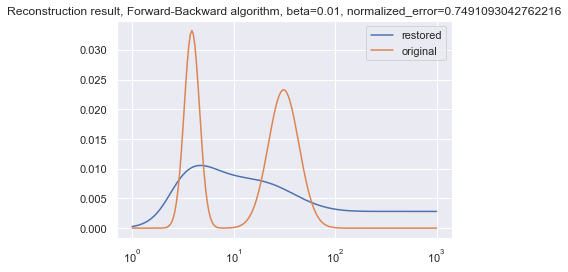

In [8]:
def for_back(beta, eps=1e-6, max_iter=1000):
    nu = np.max(abs(np.linalg.eigvals(K.T @ K)))
    # choose gamma in ]0, 2/nu[
    gamma = 1/nu
    delta = 2 - gamma*nu/2
    # choose lbda in [0, delta[
    lbda = delta/2#
    
    itr = 0
    x_n = np.zeros(x.shape)
    convergence = False
    while itr < max_iter and not convergence:
        y_n = x_n - gamma * K.T @ (K @ x_n - y.reshape(-1,1))
        x_n1 = x_n + lbda * (prox_g(y_n, gamma = gamma * beta) - x_n)
        if np.isinf(x_n1).any():
            raise ValueError
        error = np.linalg.norm(x_n1 - x_n, ord=2) / np.linalg.norm(x_n, ord=2)
        if error < eps : 
            convergence = True
        x_n = x_n1
        
        itr += 1
        
    return x_n, error
    
beta=1e-2
x_rec_FB, error = for_back(beta, eps=1e-6, max_iter=1000)
rec_error = np.linalg.norm(x-x_rec_FB, ord=2)/np.linalg.norm(x, ord=2)
fg, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(T_n_exp, x_rec_FB, label='restored')
ax.plot(T_n_exp, x, label='original')
ax.legend()
ax.set_title('Reconstruction result, Forward-Backward algorithm, beta={0}, normalized_error={1}'.format(beta, 
                                                                                                    rec_error))

The use of the exp makes the implementation numerically instable which does not allow to reduce the beta parameter to smaller values.

#### Douglas-Rachford Algorithm 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


Text(0.5, 1.0, 'Reconstruction result, Douglas-Rashford algorithm, beta=0.001, normalized_error=0.7018906601743213')

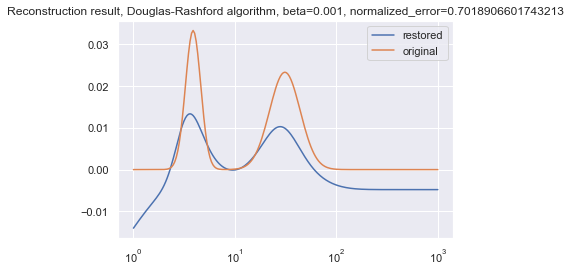

In [11]:
def doug_rach(beta, eps=1e-6, max_iter=1000):
    nu = np.max(abs(np.linalg.eigvals(K.T @ K)))
    # choose gamma in ]0, 2/nu[
    gamma = 1 #1/nu
    delta = 2 - gamma*nu/2
    # choose lbda in [0, delta[
    lbda = 1/2 #delta/2#
    
    itr = 0
    x_n = np.zeros(x.shape) #np.random.random(x.shape)
    convergence = False
    while itr < max_iter and not convergence:
        y_n = prox_g(x_n, gamma = beta)
        z_n = prox_f(2 * y_n - x_n, K, y.reshape(-1,1)) 
        x_n1 = x_n + lbda * (z_n - y_n)
        if np.isinf(x_n1).any():
            raise ValueError
        error = np.linalg.norm(x_n1 - x_n, ord=2) / np.linalg.norm(x_n, ord=2) 
        if error < eps : 
            convergence = True
        x_n = x_n1 
        
        itr += 1
        
    return x_n, error

beta = 1e-3 #0.000159
x_rec_DR, error = doug_rach(beta, eps=1e-6, max_iter=1000)
rec_error = np.linalg.norm(x-x_rec_DR, ord=2)/np.linalg.norm(x, ord=2)
fg, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(T_n_exp, x_rec_DR, label='restored')
ax.plot(T_n_exp, x, label='original')
ax.legend()
ax.set_title('Reconstruction result, Douglas-Rashford algorithm, beta={0}, normalized_error={1}'.format(beta, 
                                                                                                    rec_error))

### Question 6

#### Choosing $\beta$ for each value of $q$

With a fixed number of evaluation $n$ we want to get closer to the mimimum. 

To solve this probleme one can use the golden section search method.
We assume that the minimum of  $\beta \mapsto error(\beta)$ is between two value $a,b$ (one can just take a small enough value for $a$ and a high enough value for $b$). 


We initialize the algortihm with $\beta_0 = a$ and $\beta_3 = b$. 


At each iteration, we take 2 values for $\beta$ subject to 
$$\beta_1 = \beta_0 + \frac{3- \sqrt{5}}{2}(\beta_3 - \beta_0)$$ 
$$\beta_2 = \beta_0 + \frac{\sqrt{5}-1}{2}(\beta_3 - \beta_0)$$ 
then if  $error(\beta_1)< error(\beta_2)$ : we iterate with $\beta_3 :=\beta_2$ else $\beta_0 := \beta_1$ 

Under the assumption that there is only one local minimum for $\beta$ and that the initialization segment is big enough, we approximate the optimal value for $\beta$.

In [12]:
def golden_section_search(function, x, beta_range, tol=1e-8, it_max=100):
    beta0, beta3 = beta_range
    error = []
    betas = []
    golden_section_gamma = [(3 - np.sqrt(5))/2 , (np.sqrt(5)-1)/2]
    best_beta = {}
    it = 0
    converged = False
    while not converged and (it < it_max):
        it=it+1
        beta1 = beta0 + golden_section_gamma[0] * (beta3 - beta0)
        beta2 = beta0 + golden_section_gamma[1] * (beta3 - beta0)

        x_rec_1, _ = function(10**beta1)
        rec_error1 = np.linalg.norm(x-x_rec_1, ord=2)/np.linalg.norm(x, ord=2)
        betas.append(10**beta1)
        error.append(rec_error1)

        x_rec_2, _ = function(10**beta2)
        rec_error2 = np.linalg.norm(x-x_rec_2, ord=2)/np.linalg.norm(x, ord=2)
        betas.append(10**beta2)
        error.append(rec_error2)

        converged = (abs(rec_error2 - rec_error1)<tol)
        if rec_error1 < rec_error2 : 
            beta0, beta3 = beta0, beta2
        else: 
            beta0, beta3 = beta1, beta3
    if converged :
        print('optimal value reached for : beta = {:.2e}'.format(10**beta1))
    end = time.time()

    x_rec, error = function(10**beta1)
    rec_error = np.linalg.norm(x-x_rec, ord=2)/np.linalg.norm(x, ord=2)
    fg, ax = plt.subplots(1,1)
    ax.set_xscale('log')
    ax.plot(T_n_exp, x_rec, label='restored')
    ax.plot(T_n_exp, x, label='original')
    ax.legend()
    ax.set_title('Reconstruction result, Sparsity prior, \nbeta={0:.2e}, normalized_error={1:.3f}'.format(
                                                                            10**beta1, rec_error))

In [13]:
golden_section_search(for_back, x, beta_range=[-10,-1], tol=1e-8, it_max=1000)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


ValueError: 

In [14]:
golden_section_search(doug_rach, x, beta_range=[-10,-1], tol=1e-8, it_max=1000)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in matmul
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app


ValueError: 

### Question 7

Just comment visually the obtained curve with the ones from the previous TP.

### Question 8